# Training8

In this notebook file, Sample1 sample will be read from pkl file.

Input(X) and Output(Y) numpy arrays will be created from pandas dataframes.

The MobileNetV2 pre-trained model will be load and used.

The pre-trained model will be set to non-trainable and will only be used for feature extraction.

Training will only be performed on the fully connected layers and the output layer, that will be added to the end of the pre-trained model.

In this way, the experience gained by the model on very large data sets will be used for this classification problem.

This method is known as [**Transfer Learning**](https://en.wikipedia.org/wiki/Transfer_learning "wikipedia").

A keras utils Sequence class will be defined so that operations can be performed on the data to be used during the training.

Performance will be checked with Validation data while training model with Augmented Training data.

Accuracy and Loss charts will be drawn according to epoch numbers.

The results obtained by evaluating the model with Test data will be printed.

Based on the Test data, prediction distribution charts will be drawn for each label.

In [1]:
#Libraries are being imported
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Library versions are being printed
print('numpy Version: ' + np.__version__)
print('pandas Version: ' + pd.__version__)
print('tensorflow Version: ' + tf.__version__)
print('matplotlib Version: ' + matplotlib.__version__)

numpy Version: 1.22.3
pandas Version: 1.4.3
tensorflow Version: 2.6.0
matplotlib Version: 3.5.2


In [3]:
#GPU will be used for training
myGPU = tf.test.gpu_device_name()
if myGPU:
    print(myGPU)
else:
    print("Error")

/device:GPU:0


In [4]:
#BatchSize and EpochNumber constants are being defined
BATCH_SIZE = 32
EPOCH_NUMBER = 25

In [5]:
#The Labels are being read from json file
labelDf = pd.read_json('../../Data/RawData/Label/Label.json')
labelDf

,Name
0,Angry
1,Disgust
2,Fear
3,Happy
4,Sad
5,Surprise
6,Neutral


In [6]:
#Sample1 Training data is being read from pkl file
trainingDf = pd.read_pickle("../../Data/Sample1/Training.pkl")
trainingDf

,Label,ImageBGR
0,3,"[[[165, 186, 207], [165, 186, 207], [160, 181,..."
1,5,"[[[215, 210, 212], [136, 131, 138], [115, 111,..."
2,1,"[[[0, 2, 0], [0, 2, 0], [0, 2, 0], [0, 2, 0], ..."
3,0,"[[[27, 31, 36], [27, 31, 36], [26, 30, 34], [2..."
4,6,"[[[160, 186, 200], [160, 186, 200], [163, 188,..."
...,...,...
16295,6,"[[[211, 234, 249], [211, 234, 249], [208, 232,..."
16296,5,"[[[210, 72, 53], [210, 72, 53], [210, 72, 53],..."
16297,3,"[[[196, 196, 196], [196, 196, 196], [196, 196,..."
16298,6,"[[[204, 221, 224], [201, 218, 221], [197, 214,..."


In [7]:
#trainingX is being extracted from trainingDf as wanted shape
#trainingX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Since the pre-trained model to be used in this notebook, MobileNetV2, trained with RGB color ordered images by default,
#all images are being converted from BGR color order to RGB color order.
#[:, :, :, ::-1] code swaps the first and last channels of each image in a numpy array containing 3 channel images
#This way all images can be converted from BGR color order to RGB color order in one line

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

#Converting pixel values to range [-1, 1] in this section is an option
#Doing this once over the entire array now will be save time
#This is not how the conversion will be done because of some memory problems in this project
#Images are of data type np.uint8 when they are in the range [0, 255]
#np.uint8 requires 1 byte memory while np.float32 requires 4 byte and np.float64 requires 8 byte
#See https://www.educba.com/numpy-data-types/
#When np.uint8 data type, images use about 1GB memory
#Even if these pixel values are converted to np.float32 data type, it will need about 4GB of memory
#The computer used for this project has 8GB Ram
#Considering operating system requirements, memory required by the model, etc. 8GB Ram is not enough for this process
#For this reason, this method is not preferred, although it will save time

#Data augmentation, can also be done in Data Preparation process or this section to save time
#But this method is not preferred due to the same memory problems

trainingX = np.array(trainingDf.ImageBGR.values.tolist())[:, :, :, ::-1]
trainingX.shape

(16300, 224, 224, 3)

In [8]:
#trainingY is being extracted from trainingDf as wanted shape
trainingY = np.array(trainingDf.Label.values.tolist()).reshape((-1,1))
trainingY.shape

(16300, 1)

In [9]:
#The dataframe is being deleted because the trainingDf will no longer be needed
del trainingDf

In [10]:
#Sample1 Validation data is being read from pkl file
validationDf = pd.read_pickle("../../Data/Sample1/Validation.pkl")
validationDf

,Label,ImageBGR
0,4,"[[[7, 4, 13], [7, 4, 13], [7, 4, 13], [6, 4, 1..."
1,3,"[[[36, 44, 51], [36, 44, 51], [37, 44, 52], [3..."
2,3,"[[[37, 39, 80], [39, 41, 82], [43, 45, 86], [4..."
3,6,"[[[247, 247, 247], [248, 248, 248], [247, 247,..."
4,3,"[[[83, 193, 199], [76, 193, 198], [76, 193, 19..."
...,...,...
2712,0,"[[[115, 105, 88], [115, 105, 88], [115, 105, 8..."
2713,6,"[[[134, 136, 156], [120, 124, 148], [106, 115,..."
2714,4,"[[[168, 151, 142], [167, 150, 141], [166, 149,..."
2715,5,"[[[231, 238, 235], [231, 238, 235], [230, 237,..."


In [11]:
#validationX is being extracted from validationDf as wanted shape
#validationX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Since the pre-trained model to be used in this notebook, MobileNetV2, trained with RGB color ordered images by default,
#all images are being converted from BGR color order to RGB color order.
#[:, :, :, ::-1] code swaps the first and last channels of each image in a numpy array containing 3 channel images
#This way all images can be converted from BGR color order to RGB color order in one line

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

#Converting pixel values to range [-1, 1] in this section is an option
#Doing this once over the entire array now will be save time
#This is not how the conversion will be done because of some memory problems in this project
#Images are of data type np.uint8 when they are in the range [0, 255]
#np.uint8 requires 1 byte memory while np.float32 requires 4 byte and np.float64 requires 8 byte
#See https://www.educba.com/numpy-data-types/
#When np.uint8 data type, images use about 1GB memory
#Even if these pixel values are converted to np.float32 data type, it will need about 4GB of memory
#The computer used for this project has 8GB Ram
#Considering operating system requirements, memory required by the model, etc. 8GB Ram is not enough for this process
#For this reason, this method is not preferred, although it will save time

validationX = np.array(validationDf.ImageBGR.values.tolist())[:, :, :, ::-1]
validationX.shape

(2717, 224, 224, 3)

In [12]:
#validationY is being extracted from validationDf as wanted shape
validationY = np.array(validationDf.Label.values.tolist()).reshape((-1,1))
validationY.shape

(2717, 1)

In [13]:
#The dataframe is being deleted because the validationDf will no longer be needed
del validationDf

In [14]:
#MobileNetV2 pre-trained model is being loaded
#The original MobileNetV2 model was trained with images with size of (224, 224, 3) 
#in RGB color order and pixel values of [-1, 1] (zero centered) as default
#See https://keras.io/api/applications/mobilenet/ for more information
#Since images of dataset saved as size of (224, 224, 3) in BGR color order and pixel values of [0, 255]
#Color order changed from BGR to RGB while preparing trainingX and validationX
#Pixel values will be converted to [-1, 1] range during training with the help of keras utils Sequence class

#Model is set to non-trainable
#In this way, the convolutional layers that will be used for feature extraction will be used without changing them
#Output layer will be fed the feature-map obtained from the pre-trained convolutional model
#the training process will be performed on this layer

model = tf.keras.applications.MobileNetV2(include_top = False, weights = 'imagenet', input_shape = ((224, 224, 3)))
model.trainable = False
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [15]:
#The pre-trained model is being connected to the Average Pooling layer
#A dropout layer is added to the the model to prevent overfitting,
#and the model is completed with the addition of the output layer
model = tf.keras.models.Sequential([
    model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(labelDf.shape[0], activation = tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
#Model is being compiled with Adam optimizer
#Adam optimizer is a common used optimizer
#See https://keras.io/api/optimizers/adam/
#See also https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
#SparseCategoricalCrossentropy loss function is being used because of the label format of the data
#SparseCategoricalAccuracy is being used as metric because of the label format of the data
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')]
)

In [17]:
#A class inherited from keras utils Sequence is being created
class FitSequence(tf.keras.utils.Sequence):
    
    #Constructor method is being defined
    def __init__(self, image, label, batchSize, imagesPerImage):
        self.image, self.label = image, label
        self.batchSize = batchSize
        
        #A numpy array for image indexes is being created
        #This array will be used to shuffle the data
        self.index = np.arange(self.image.shape[0])
        self.imagesPerImage = imagesPerImage
        
        #batch sizes are being calculated for correct information during training
        self.originalBatch = self.image.shape[0] / float(self.batchSize)
        self.batchLen = int(np.ceil(self.originalBatch * self.imagesPerImage))
        self.originalBatch = int(np.ceil(self.originalBatch))
        self.repeatData = -1
        
        #Image Augmentation layer
        #See https://www.tensorflow.org/tutorials/images/data_augmentation
        self.imageAugmentation = tf.keras.Sequential([
          tf.keras.layers.RandomFlip("horizontal_and_vertical"),
          tf.keras.layers.RandomRotation(0.2),
        ])
        

    #__len__ method is being defined
    #This method will be used by the model to show the amount of progress of each epoch
    def __len__(self):
        return self.batchLen

    #__getitem__ method is being defined
    #The model will retrieve the batches it will use during training by calling this method
    #With this method, the data to be used by the model can be manipulated
    def __getitem__(self, idx):
        
        #Since randomly augmented images obtained from the same image will be added to the batches,
        #there will be more batches than expected
        #so the taken index is updated by taking the mode according to the original batch
        idx = idx % self.originalBatch
        
        #If the index is 0, that is, the loop in the epoch has returned to the beginning
        if idx == 0:
            
            #The index array is being shuffled
            #so that the data in the next repeat is returned in different orders
            np.random.shuffle(self.index)
            
            #repeatData is being incremented by 1
            self.repeatData += 1
            
        #When the model requests data, the next batch size will be selected based on index array
        indexPart = self.index[idx * self.batchSize : (idx + 1) * self.batchSize]
        
        #if it is the first iteration of data in the epoch,
        #selected data from data in original list are being returned
        if self.repeatData == 0:
            return self.__OriginalBatch(indexPart)
        
        #if it is not the first iteration of data in the epoch,
        #data augmented using select data are being returned
        else:
            return self.__AugmentedBatch(indexPart)
        
    #on_epoch_end method is being defined
    #The model will call this method after each epoch is ended
    def on_epoch_end(self):
        
        #repeatData is updated to -1 at the end of each epoch
        self.repeatData = -1
    
    #this method will be called if element from original list will be returned
    def __OriginalBatch(self, indexPart):
        
        #Before being sent to the model on demand pixel values will be converted to range [-1, 1]
        #Doing this operation here means that it will be repeated as many epochs for each image and this wastes time
        #This is how the conversion is being done because of some memory problem in this project
        batchX = (self.image[indexPart] / 127.5) - 1
        batchY = self.label[indexPart]
        return np.array(batchX), np.array(batchY)
    
    #This method will be called if images created with the data augmentation method will be returned
    #Doing Data Augmentation operation here means that it will be repeated as many epochs for each image and this wastes time
    #On the other hand, since the data augmentation process is done with random rotation and random flip,
    #different variations can be obtained of the original image each time
    #This can be have a preventative effect on overfitting
    def __AugmentedBatch(self, indexPart):
        augmentedList = []
        for i in indexPart:
            augmentedList.append(self.imageAugmentation(self.image[i]))
        
        #Before being sent to the model on demand pixel values will be converted to range [-1, 1]
        #Doing this operation here means that it will be repeated as many epochs for each image and this wastes time
        #This is how the conversion is being done because of some memory problem in this project
        batchX = (np.array(augmentedList) / 127.5) - 1
        batchY = self.label[indexPart]
        return np.array(batchX), np.array(batchY)

In [18]:
#model is being trained with EPOCH_NUMBER epochs and BATCH_SIZE batchSize using GPU

#3 more images will be obtained from each original for training data so the number of images will be quadrupled
#Only the originals of the validation data will be used

with tf.device(myGPU):
    trainingHistory = model.fit(
        FitSequence(trainingX, trainingY, BATCH_SIZE, 4),
        epochs = EPOCH_NUMBER,
        validation_data = FitSequence(validationX, validationY, BATCH_SIZE, 1)
    )

Epoch 1/25
2038/2038 [==============================] - 1868s 822ms/step - loss: 1.3783 - accuracy: 0.4998 - val_loss: 1.2801 - val_accuracy: 0.5340
Epoch 2/25
2038/2038 [==============================] - 1596s 783ms/step - loss: 1.3045 - accuracy: 0.5248 - val_loss: 1.2623 - val_accuracy: 0.5451
Epoch 3/25
2038/2038 [==============================] - 1671s 820ms/step - loss: 1.3036 - accuracy: 0.5253 - val_loss: 1.2710 - val_accuracy: 0.5469
Epoch 4/25
2038/2038 [==============================] - 1373s 673ms/step - loss: 1.2749 - accuracy: 0.5375 - val_loss: 1.2424 - val_accuracy: 0.5723
Epoch 5/25
2038/2038 [==============================] - 1077s 528ms/step - loss: 1.2406 - accuracy: 0.5518 - val_loss: 1.2680 - val_accuracy: 0.5679
Epoch 6/25
2038/2038 [==============================] - 1490s 731ms/step - loss: 1.2888 - accuracy: 0.5324 - val_loss: 1.2379 - val_accuracy: 0.5440
Epoch 7/25
2038/2038 [==============================] - 1776s 871ms/step - loss: 1.2975 - accuracy: 0.5266

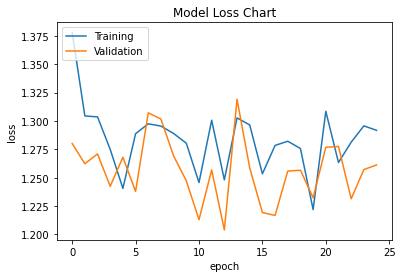

In [19]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['loss'])
plt.plot(trainingHistory.history['val_loss'])

#Chart Tittle
plt.title('Model Loss Chart')

#Chart Labels
plt.ylabel('loss')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

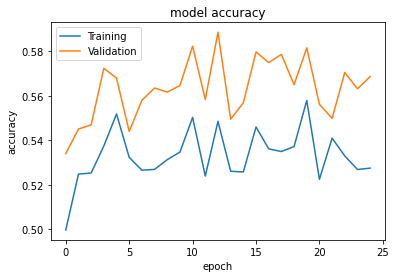

In [20]:
#Accuracy Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['accuracy'])
plt.plot(trainingHistory.history['val_accuracy'])

#Chart Tittle
plt.title('model accuracy')

#Chart Labels
plt.ylabel('accuracy')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

In [21]:
#Sample1 Test data is being read from pkl file
testDf = pd.read_pickle("../../Data/Sample1/Test.pkl")
testDf

,Label,ImageBGR
0,0,"[[[62, 121, 130], [61, 120, 129], [60, 114, 12..."
1,0,"[[[65, 77, 105], [65, 77, 105], [65, 77, 105],..."
2,6,"[[[181, 183, 193], [180, 182, 192], [179, 181,..."
3,6,"[[[6, 11, 10], [5, 10, 9], [5, 10, 9], [4, 9, ..."
4,4,"[[[17, 19, 13], [16, 18, 12], [16, 18, 12], [1..."
...,...,...
2712,3,"[[[192, 194, 194], [192, 194, 194], [192, 194,..."
2713,3,"[[[249, 249, 249], [249, 249, 249], [250, 250,..."
2714,6,"[[[233, 221, 217], [233, 221, 217], [234, 222,..."
2715,6,"[[[24, 30, 59], [24, 30, 59], [25, 31, 59], [2..."


In [22]:
#testX is being extracted from testDf as wanted shape

#Since the pre-trained model to be used in this notebook, MobileNetV2, trained with RGB color ordered images by default,
#all images are being converted from BGR color order to RGB color order.
#[:, :, :, ::-1] code swaps the first and last channels of each image in a numpy array containing 3 channel images
#This way all images can be converted from BGR color order to RGB color order in one line

testX = np.array(testDf.ImageBGR.values.tolist())[:, :, :, ::-1]
testX.shape

(2717, 224, 224, 3)

In [23]:
#testY is being extracted from testDf as wanted shape
testY = np.array(testDf.Label.values.tolist()).reshape((-1,1))
testY.shape

(2717, 1)

In [24]:
#The dataframe is being deleted because the testDf will no longer be needed
del testDf

In [25]:
#Model is being evaluated with test data
#Sequence class is being also used for evaluation to convert test data into the same format as training data
testResult = model.evaluate(FitSequence(testX, testY, BATCH_SIZE, 1))

85/85 [==============================] - 67s 780ms/step - loss: 1.3471 - accuracy: 0.5090


In [26]:
#Test Loss is being Printed
print('Test Loss: ' + str(testResult[0]))

Test Loss: 1.347059726715088


In [27]:
#Test Accuracy is being Printed
print('Test Accuracy: ' + str(testResult[1]))

Test Accuracy: 0.509017288684845


In [28]:
#in this block, testX prediction results are being converted in same format as testY
resultList = []
for i in range((testX.shape[0] // 8) + 1):
    #testX is being sliced to Batches
    testSlice = (testX[i * 8: (i + 1) * 8] / 127.5) - 1
    if testSlice.shape[0] > 0:
        #The testX data is sent to the predict function and the results are being stored in the testPredict
        #testPredict results are a numpy array of float type and size of labelDf.shape[0] for each X
        #in this case shape of testPredict is (BATCH_SIZE,  labelDf.shape[0])
        #This is because the deep learning model used returns the results as one-hot encoded
        #See https://en.wikipedia.org/wiki/One-hot 
        #for learn more about one-hot encoding
        #The process applied in this project is a classification
        #One-hot encoding is frequently used in classification processes
        testPredict = model.predict(testSlice)
        for j in range(testPredict.shape[0]):
            #The data stored as one-hot in testPredict is being converted to sparse categorical format like testY 
            #by taking the index of the maximum value with the argmax function
            
            #See also
            #https://medium.com/low-code-for-advanced-data-science/dealing-with-sparse-categorical-variables-in-predictive-modeling-6d9548e22e7f
            resultList.append(testPredict[j].argmax(axis=0))
result = np.array(resultList).reshape((-1,1))
#the shape of result array, same as testY as can be seen
result.shape

(2717, 1)

In [29]:
#A kind of confusion matrix and total array for number of each label is being created on this block
#See https://en.wikipedia.org/wiki/Confusion_matrix 
#for more details about confusion matrix
total = np.zeros(labelDf.shape[0], np.int32).reshape((-1,1))
confusionMatrix = np.zeros([labelDf.shape[0], labelDf.shape[0]])
for i in range(result.shape[0]):
    #total counts for each label
    total[testY[i]] += 1
    #rows of confusionMatrix indicates each label and columns indicates predicted labels
    confusionMatrix[testY[i], result[i]] += 1

#To examine, confusionMatrix[1, 1] indicates how many of the data with label 1
#are predicted correctly according to the predict results
#and confusionMatrix[1, 2] shows how many of the data with label 1 were predicted as label 2
confusionMatrix

array([[  8.,   0.,   0.,  88.,   1.,   5.,  47.],
       [  0.,   2.,   0.,  52.,   2.,   1.,  78.],
       [  1.,   0.,   0.,  11.,   1.,   5.,   7.],
       [  3.,   2.,   0., 854.,   2.,   5., 194.],
       [  4.,   3.,   0., 104.,  12.,   9., 127.],
       [  4.,   2.,   1.,  91.,   5.,  69.,  77.],
       [  0.,   4.,   0., 291.,   1.,  13., 531.]])

In [30]:
#in this block the rates are being calculated for the confusion matrix
confusionMatrix = confusionMatrix / total
confusionMatrix

array([[0.05369128, 0.        , 0.        , 0.59060403, 0.00671141,
        0.03355705, 0.31543624],
       [0.        , 0.01481481, 0.        , 0.38518519, 0.01481481,
        0.00740741, 0.57777778],
       [0.04      , 0.        , 0.        , 0.44      , 0.04      ,
        0.2       , 0.28      ],
       [0.00283019, 0.00188679, 0.        , 0.80566038, 0.00188679,
        0.00471698, 0.18301887],
       [0.01544402, 0.01158301, 0.        , 0.4015444 , 0.04633205,
        0.03474903, 0.49034749],
       [0.01606426, 0.00803213, 0.00401606, 0.36546185, 0.02008032,
        0.27710843, 0.30923695],
       [0.        , 0.0047619 , 0.        , 0.34642857, 0.00119048,
        0.01547619, 0.63214286]])

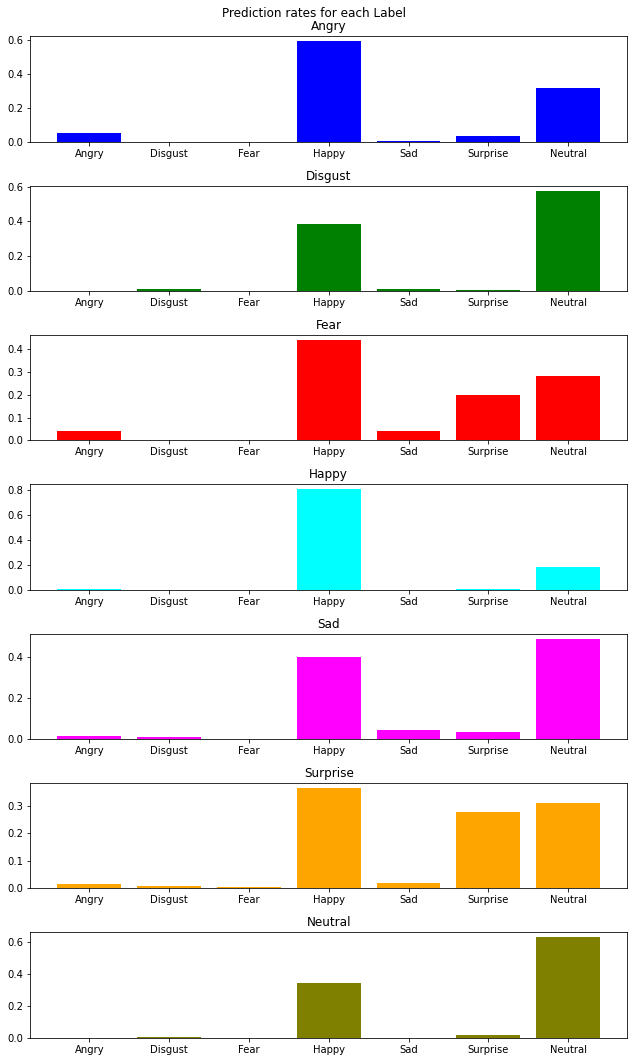

In [31]:
#label list is being created
labels = labelDf.Name.values.tolist()

#length of label list is being calculated
lenLabel = len(labels)

#color list is being defined
colorList = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange', 'olive']

#Figure and Axes are being defined
fig, ax = plt.subplots(lenLabel, figsize=(9, 15))

#Figure title is being defined
fig.suptitle('Prediction rates for each Label')

#Each row of the confusion matrix is added to the charts as separate chart
for i in range(lenLabel):
    ax[i].bar(labels, confusionMatrix[i], color = colorList[(i % len(colorList))])
    ax[i].set_title(labels[i])

#For better format
fig.tight_layout()

#show plot
plt.show()

# Training8 Inference

By looking at the accuracy, loss and prediction distribution charts, it can be seen that learning does not take place.

A similar architecture was trained with same data in the Training4 notebook file without the Transfer Learning method.

In this example, transfer learning did not reach the expected level.

Performance can be improved by trying Hyperparameter Optimization methods.

See https://en.wikipedia.org/wiki/Hyperparameter_optimization.